# Sentiment Analysis of Elon Musk's tweets: The effect on Tesla's stocks

The main aim of this project is to investigate if there's a correlation between any company owner's tweets; be it positive or negative, and the effect on their company's stocks.   
In this case, we're using Elon Musk and his Tesla company from 2022-07-25 to 2022-07-31 (present) as our use case.     
   
For our analysis to be more reasonable in checking the effect of tweets against stocks, the stocks data used were for exactly 10 minutes after Elon made the tweets. Thereby giving others time to cause changes in the stocks or not.


To perform this analysis, we've built two bots; 
- first one is a twitter bot to pull Elon Musk's tweets from Twitter. You can check out the codefile 'twitter_bot.py'
- second one is a stocks bot that pulls Tesla's stocks data from Yahoo Finance. You can check out the codefile 'tesla_stocks_bot.py'

The data is specifically for a duration of a week; this is because the only available stocks data per minute from the Yahoo Finance API only covers a week.

### Run the twitter bot

In [1]:
#%run twitter_bot.py

### Let's load the csv file of the tweets that the bot pulled

In [2]:
import pandas as pd

In [3]:
elon_tweets = pd.read_csv('data/elons_tweets.csv', usecols = ['Date', 'Tweet'])

elon_tweets

,Date,Tweet
0,2022-07-31 22:38:29+00:00,@dcherring 👍
1,2022-07-31 22:37:39+00:00,@dogeofficialceo https://t.co/QMyM1H0Z5y
2,2022-07-31 22:32:36+00:00,If our reality is actually an alien soap opera...
3,2022-07-31 21:39:40+00:00,@WholeMarsBlog 🤣
4,2022-07-31 14:22:14+00:00,Maybe free some people in jail for weed here t...
...,...,...
76,2022-07-25 02:24:00+00:00,@heydave7 @WholeMarsBlog @WSJ WSJ has run so m...
77,2022-07-25 02:09:07+00:00,@WholeMarsBlog Haven’t even had sex in ages (s...
78,2022-07-25 02:07:14+00:00,"@TeslaHype @WholeMarsBlog Yeah, the character ..."
79,2022-07-25 01:59:31+00:00,@WholeMarsBlog This is total bs. Sergey and I ...


From this, Taking a peek at the tweets showed that we have the complete date range we specified.   
And also that the tweets data aren't clean. We will have to perform data cleaning and extraction to get cleaner tweets   

We'll start by checking for null values

In [4]:
elon_tweets.isnull().sum()

Date     0
Tweet    0
dtype: int64

Since there's no null values, we're good to go.   

The next step is to remove the @tags, links (http...), #hashtags and remove all other characters that aren't letters such as emojis, + and others, since we're to work on sentiment analysis whose most important input are the words (letters)

### Preprocessing the tweets

In [5]:
import preprocessor as tweet_preprocesor
import re

from nltk.corpus import stopwords

In [6]:
#Remove all the #hashtags and keep the word, like #elonmusk -> elonmusk
elon_tweets['Tweet'] = elon_tweets['Tweet'].replace('#', '', regex = True)

In [7]:
#Then we use the tweet_preprocessor to remove urls, mentions, reserved words, emojis, smileys and numbers
elon_tweets['Tweet'] = elon_tweets['Tweet'].apply(tweet_preprocesor.clean)

In [8]:
#Now taking a look at the new tweets column
elon_tweets['Tweet']

0                                                      
1                                                      
2     If our reality is actually an alien soap opera...
3                                                      
4     Maybe free some people in jail for weed here too?
                            ...                        
76    WSJ has run so many bs hit pieces on me and Te...
77                   Havent even had sex in ages (sigh)
78    Yeah, the character assassination attacks have...
79    This is total bs. Sergey and I are friends and...
80    Ironic that Disney would disparage an entire c...
Name: Tweet, Length: 81, dtype: object

We can now observe that all of the urls, mentions, reserved words, emojis, smileys and numbers have been removed.   


But we can still observe the punctuation, so we'll remove that

In [9]:
elon_tweets['Tweet'] = elon_tweets['Tweet'].replace(r'[^\w\s]+', '', regex = True)

In [10]:
#Checking the tweets column again
elon_tweets['Tweet']

0                                                      
1                                                      
2     If our reality is actually an alien soap opera...
3                                                      
4      Maybe free some people in jail for weed here too
                            ...                        
76    WSJ has run so many bs hit pieces on me and Te...
77                     Havent even had sex in ages sigh
78    Yeah the character assassination attacks have ...
79    This is total bs Sergey and I are friends and ...
80    Ironic that Disney would disparage an entire c...
Name: Tweet, Length: 81, dtype: object

We can now remove stopwords

In [11]:
stop_words = stopwords.words('english')
pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')   #Create a regular expression composing of all the English stopwords

elon_tweets['Tweet'] = elon_tweets['Tweet'].apply(lambda x: pattern.sub('', x))
#Replace the stop words with empty space

In [12]:
#Taking a look at the tweets now
elon_tweets['Tweet']

0                                                      
1                                                      
2     If reality actually alien soap opera ratings w...
3                                                      
4                          Maybe free people jail weed 
                            ...                        
76    WSJ run many bs hit pieces Tesla Ive lost coun...
77                            Havent even sex ages sigh
78    Yeah character assassination attacks reached n...
79    This total bs Sergey I friends party together ...
80    Ironic Disney would disparage entire class rod...
Name: Tweet, Length: 81, dtype: object

In [13]:
#The dataset is way neater now, but there are more whitespaces than usual in some rows
elon_tweets['Tweet'] = elon_tweets['Tweet'].apply(lambda x: ' '.join(x.split()))

In [14]:
#Yeah, so the data is way cleaner now, but some rows are completely empty, like row[[0, 1, 3...]].
#We'll remove empty columns like that.
elon_tweets['Tweet'].isnull().sum()

0

In [15]:
#It doesn't recognize the empty row, meaning there's probably a value like '' which isn't np.nan
(elon_tweets['Tweet'] == '').sum()

10

In [16]:
#So, working with only tweets that have real tweets in them after the cleaning
elon_tweets = elon_tweets[elon_tweets['Tweet'] != ''].reset_index().drop('index', axis = 1)

elon_tweets

,Date,Tweet
0,2022-07-31 22:32:36+00:00,If reality actually alien soap opera ratings w...
1,2022-07-31 14:22:14+00:00,Maybe free people jail weed
2,2022-07-31 14:11:35+00:00,Good thread
3,2022-07-31 02:28:06+00:00,Sigh
4,2022-07-31 02:27:16+00:00,Off Races set Harley Quinn
...,...,...
66,2022-07-25 02:24:00+00:00,WSJ run many bs hit pieces Tesla Ive lost coun...
67,2022-07-25 02:09:07+00:00,Havent even sex ages sigh
68,2022-07-25 02:07:14+00:00,Yeah character assassination attacks reached n...
69,2022-07-25 01:59:31+00:00,This total bs Sergey I friends party together ...


So, we're good to go with cleaning the tweets.   

Let's now build the Basic sentiment analyzer and the NLTK Vader sentiment analyzer   

### Starting with the Basic sentiment analyzer that uses a custom bag of words compiled by Minqing Hu and Bing Liu

In [17]:
class BasicSentimentAnalyzer():
    """This analyzer uses a bag of words containing positive and negative words and thereby produces the sentiment of that text depending on the score"""
    def __init__(self):
        self.all_words_with_scores = {}   #Initialize a dictionary variable which will hold all the words with their scores
        
        
    def read_pos_neg_path(self, pos_words_path, neg_words_path):
        """The function reads the words and scores them according to the file path, 1 for positive words and -1 for negative words which is then summed or 
        subtracted to analyze the sentiment of any sentence"""
        with open(pos_words_path, 'r') as p_words:
            positive_words = [line.strip() for line in p_words]   #Read the words in the positive words file line by line
        with open(neg_words_path, 'r') as n_words:
            negative_words = [line.strip() for line in n_words]   #Read the words in the negative words file line by line
            
        for p_word in positive_words:
            if p_word.startswith(';') or p_word == '':
                continue   #This is to skip the documentation in the text file
            
            self.all_words_with_scores[p_word] = 1   #Set the score for positive words to 1
            
        for n_word in negative_words:
            if n_word.startswith(';') or n_word == '':
                continue   #This is to skip the documentation in the text file
            
            self.all_words_with_scores[n_word] = -1   #Set the score for negative words to -1
        
        return self
    
    def classify_new_text(self, new_text):
        """Classifies a text and returns a value if Positive, Negative or Neutral depending on the sentiment of the text"""
        new_text = new_text.lower().split(' ')   
        #Change the text to lowercase since the text to be compared to is in lowercase, and split to get the individual word
        
        sentiment_value = 0
        for text in new_text:
            if text in self.all_words_with_scores:   #If the text in the text files, add or subtract the score value from the sentiment value
                text_score = self.all_words_with_scores[text]
                sentiment_value += text_score
                
        #Return 'positive, negative or neutral' depending on the final sentiment score
#         if sentiment_value == 0:
#             return 'Neutral'
#         elif sentiment_value < 0:
#             return 'Negative'
#         elif sentiment_value > 0:
#             return 'Positive'

        #We're returning the sentiment score, not categories like positive, negative and neutral because it's easier and more appealing visually to plot 
        #a curve with the numbers against the stock values compared to rigid categories
        return sentiment_value   

In [18]:
#Load the sentiment analyzer
sentiment_analyzer = BasicSentimentAnalyzer().read_pos_neg_path('data/positive-bag-of-words.txt', 'data/negative-bag-of-words.txt')

In [19]:
#Add the BSA_sentiments to the original DataFrame where BSA is the BasicSentimentAnalyzer
elon_tweets['BSA_sentiments'] = elon_tweets['Tweet'].apply(sentiment_analyzer.classify_new_text)

In [20]:
elon_tweets

,Date,Tweet,BSA_sentiments
0,2022-07-31 22:32:36+00:00,If reality actually alien soap opera ratings w...,0
1,2022-07-31 14:22:14+00:00,Maybe free people jail weed,0
2,2022-07-31 14:11:35+00:00,Good thread,1
3,2022-07-31 02:28:06+00:00,Sigh,0
4,2022-07-31 02:27:16+00:00,Off Races set Harley Quinn,0
...,...,...,...
66,2022-07-25 02:24:00+00:00,WSJ run many bs hit pieces Tesla Ive lost coun...,-3
67,2022-07-25 02:09:07+00:00,Havent even sex ages sigh,0
68,2022-07-25 02:07:14+00:00,Yeah character assassination attacks reached n...,-1
69,2022-07-25 01:59:31+00:00,This total bs Sergey I friends party together ...,0


### Onto the NLTK Sentiment Analyzer built on VADER (Valence Aware Dictionary for sEntiment Reasoning)

In [21]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [22]:
class NLTKVaderSentimentAnalyzer(SentimentIntensityAnalyzer):
    def classify_new_text(self, new_text):
        score = self.polarity_scores(new_text)['compound']   
        #Calculate the polarity score of the text using Vader
        
#         if score > 0.2:
#             return 'Positive'
#         elif score < -0.2:
#             return 'Negative'
#         else:
#             return 'Neutral'

        #We're returning the sentiment score, not categories like positive, negative and neutral because it's easier and more appealing visually to plot 
        #a curve with the numbers against the stock values compared to rigid categories
        return score

In [23]:
#Initialize the sentiment analyzer
vader_s_analyzer = NLTKVaderSentimentAnalyzer()

In [24]:
#Add the vader_sentiments to the original DataFrame
elon_tweets['vader_sentiments'] = elon_tweets['Tweet'].apply(vader_s_analyzer.classify_new_text)

In [25]:
elon_tweets

,Date,Tweet,BSA_sentiments,vader_sentiments
0,2022-07-31 22:32:36+00:00,If reality actually alien soap opera ratings w...,0,0.0000
1,2022-07-31 14:22:14+00:00,Maybe free people jail weed,0,0.5106
2,2022-07-31 14:11:35+00:00,Good thread,1,0.4404
3,2022-07-31 02:28:06+00:00,Sigh,0,0.0258
4,2022-07-31 02:27:16+00:00,Off Races set Harley Quinn,0,0.0000
...,...,...,...,...
66,2022-07-25 02:24:00+00:00,WSJ run many bs hit pieces Tesla Ive lost coun...,-3,-0.8126
67,2022-07-25 02:09:07+00:00,Havent even sex ages sigh,0,0.0258
68,2022-07-25 02:07:14+00:00,Yeah character assassination attacks reached n...,-1,-0.7650
69,2022-07-25 01:59:31+00:00,This total bs Sergey I friends party together ...,0,0.5487


Now that we're done with getting the sentiments of the tweet, both with a basic bag of words and using Natural Language Processing   

### We can now move on to run the bot to get Tesla's stocks

In [26]:
#%run tesla_stocks_bot.py

### Let's load the csv file of the stocks that the bot pulled

In [27]:
from datetime import datetime, timezone, timedelta

In [28]:
tesla_stocks = pd.read_csv('data/tesla_stocks.csv')

tesla_stocks

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2022-07-25 09:30:00-04:00,816.650024,816.799988,811.262024,813.510010,813.510010,1109730
1,2022-07-25 09:31:00-04:00,813.849976,816.799988,812.849976,814.750000,814.750000,217451
2,2022-07-25 09:32:00-04:00,815.125000,822.440002,814.295593,820.659973,820.659973,268608
3,2022-07-25 09:33:00-04:00,820.594971,820.890015,816.000122,817.505005,817.505005,205037
4,2022-07-25 09:34:00-04:00,817.609985,819.989990,813.306396,814.409973,814.409973,179416
...,...,...,...,...,...,...,...
1946,2022-07-29 15:56:00-04:00,892.299988,892.299988,891.200012,891.484985,891.484985,178085
1947,2022-07-29 15:57:00-04:00,891.530029,892.280029,890.510010,890.739990,890.739990,233226
1948,2022-07-29 15:58:00-04:00,890.739990,890.840027,889.875000,890.289978,890.289978,249277
1949,2022-07-29 15:59:00-04:00,890.190125,891.520020,890.169983,891.469971,891.469971,285609


Convert both the tesla stocks and the date of Elon's tweets to datetime object of the same timezone

In [29]:
tesla_stocks['Datetime'] = pd.to_datetime(tesla_stocks['Datetime']).dt.tz_convert(None)

#Change 'Datetime' column name to 'Date'
tesla_stocks.columns = tesla_stocks.columns.str.replace('Datetime', 'Date')

In [30]:
elon_tweets['Date'] = pd.to_datetime(elon_tweets['Date']).dt.tz_convert(None)

But from earlier Elon Tweets DataFrame, the seconds are given whereas the stocks data have no second (time.second) value.   

So, we'll be replacing the seconds in elon_tweets['Date'] to 0

In [31]:
elon_tweets['Date'] = elon_tweets['Date'].apply(lambda x: x.replace(second = 0))

Taking a look at the tesla_stocks DataFrame and the elon_tweets DataFrame after transformation

In [32]:
tesla_stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-07-25 13:30:00,816.650024,816.799988,811.262024,813.510010,813.510010,1109730
1,2022-07-25 13:31:00,813.849976,816.799988,812.849976,814.750000,814.750000,217451
2,2022-07-25 13:32:00,815.125000,822.440002,814.295593,820.659973,820.659973,268608
3,2022-07-25 13:33:00,820.594971,820.890015,816.000122,817.505005,817.505005,205037
4,2022-07-25 13:34:00,817.609985,819.989990,813.306396,814.409973,814.409973,179416


In [33]:
elon_tweets.head()

,Date,Tweet,BSA_sentiments,vader_sentiments
0,2022-07-31 22:32:00,If reality actually alien soap opera ratings w...,0,0.0000
1,2022-07-31 14:22:00,Maybe free people jail weed,0,0.5106
2,2022-07-31 14:11:00,Good thread,1,0.4404
3,2022-07-31 02:28:00,Sigh,0,0.0258
4,2022-07-31 02:27:00,Off Races set Harley Quinn,0,0.0000


> **The intention is to check the stocks at 10 minutes interval after Elon Musk made a particular tweet.**   
> **This will help in providing reasonable insights into how his stocks were affected after 10 minutes of him making a particular tweet.**   

So, we'll increase the timing and merge the tweet and stocks data at 10 minutes after the tweet was made

In [34]:
elon_tweets['Date'] = elon_tweets['Date'].apply(lambda x: x + timedelta(minutes = 10))

To make the workflow easier, we'll be merging the elon_tweets and tesla_stocks DataFrame with the same date, and dropping all the columns from the tesla_stocks except the Adjusted Close which will be used as our stock data value at any point in time because it's the adjusted stock value after accounting for any corporate actions such as stock splits and dividend distributions

In [35]:
elon_tweets = elon_tweets.merge(tesla_stocks).drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis = 1)

#Change 'Adj Close' column name to 'Stock value'
elon_tweets.columns = elon_tweets.columns.str.replace('Adj Close', 'Stock value')

elon_tweets.head()

,Date,Tweet,BSA_sentiments,vader_sentiments,Stock value
0,2022-07-29 15:22:00,Were working super hard isnt ready yet,1,0.3378,859.880005
1,2022-07-29 15:04:00,Wikipedia losing objectivity,-1,-0.3818,859.440002
2,2022-07-29 14:56:00,I cant say sure Starship reach escape velocity...,-1,0.3045,863.883728
3,2022-07-27 16:21:00,Sub lightspeed thats needed interstellar Inter...,1,-0.1280,811.652710
4,2022-07-27 16:17:00,The media clickseeking machine dressed truthse...,0,0.0000,810.969971


In [36]:
# Save the tweets_and_stocks data to csv
elon_tweets.to_csv('data/elon_tweets_and_stocks.csv')

The data is now complete...   

## Let's start with visualizing the data and providing analysis from that.

In [37]:
#Let's load the csv file of the tweets_and_stocks data saved from earlier
elon_tweets = pd.read_csv('data/elon_tweets_and_stocks.csv')

>Plotting the Stock Trends from 2022-07-25 to 2022-07-29

In [38]:
import seaborn as sns
sns.set_style("whitegrid")


import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [39]:
#Let's sort the data by the date so we have the data sorted from the 25th to the 29th
elon_tweets = elon_tweets.sort_values(by = ["Date"], ascending = True)

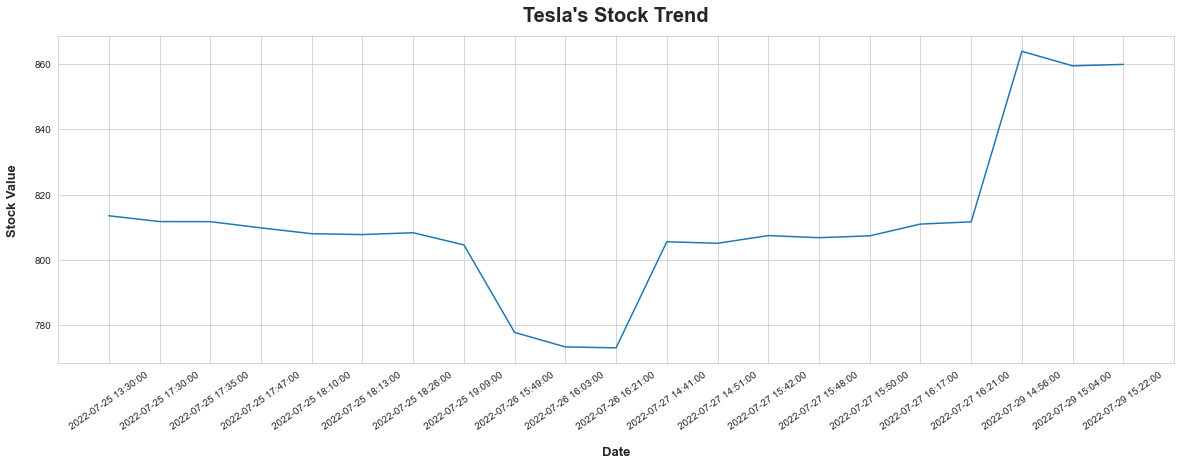

In [46]:
#Plot the data
plt.figure(figsize = (20, 6))
sns.lineplot(x = elon_tweets['Date'], y = elon_tweets["Stock value"])

plt.title("Tesla's Stock Trend", weight = "bold", fontsize = 20, pad = 15)

plt.xlabel("Date", labelpad = 15, weight = "bold", fontsize = 13)
plt.ylabel("Stock Value", labelpad = 15, weight = "bold", fontsize = 13)

plt.xticks(rotation = 35);   #Rotate the xticks so the date values can be more readable

>This gives us a visual view of the stocks of how it falls, rises and stabilizes over time.   

### Let's now plot the sentiments of Elon's tweet against the trend of the stocks.

>But before that, let's just have a visual look at the sentiments; the BSA and the Vader sentiments.

In [50]:
#Let's start with getting the amount of unique values we have per the analyzer used. This is to get a feel of the most populous sentiment of Elon's tweets.
bsa_values_sorted_by_amount = elon_tweets.BSA_sentiments.value_counts()
vader_values_sorted_by_amount = elon_tweets.vader_sentiments.value_counts()

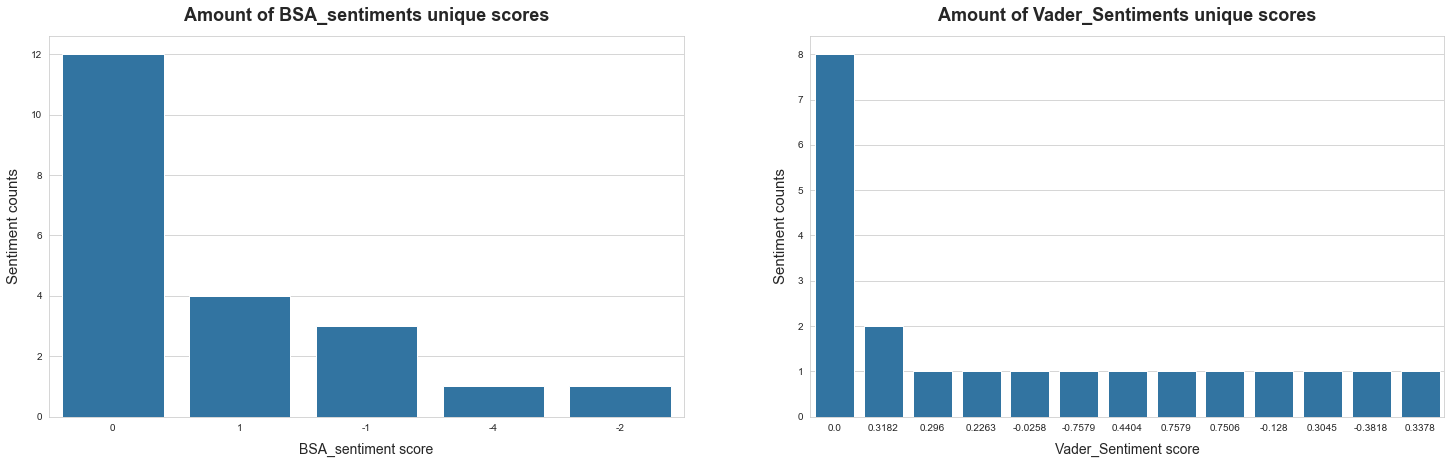

In [91]:
fig, ax = plt.subplots(1, 2, figsize = (25, 7))

#Plot the countplot of the unique values and set title
sns.countplot(elon_tweets["BSA_sentiments"], color = sns.color_palette()[0], order = bsa_values_sorted_by_amount.index, ax = ax[0])

#Set title and labels
ax[0].set_title("Amount of BSA_sentiments unique scores", weight = "bold", fontsize = 18, pad = 15)
ax[0].set_xlabel('BSA_sentiment score', fontsize = 14, labelpad = 10)
ax[0].set_ylabel('Sentiment counts', fontsize = 15, labelpad = 10)

#Plot the countplot of the unique values and set title
sns.countplot(elon_tweets["vader_sentiments"], color = sns.color_palette()[0], order = vader_values_sorted_by_amount.index, ax = ax[1])

#Set title and labels
ax[1].set_title("Amount of Vader_Sentiments unique scores", weight = "bold", fontsize = 18, pad = 15)
ax[1].set_xlabel('Vader_Sentiment score', fontsize = 14, labelpad = 10)
ax[1].set_ylabel('Sentiment counts', fontsize = 15, labelpad = 10);

From the graphs of both sentiment analyzers, it's observed that the most number of values are for sentiment score of 0, meaning most of his tweets for the period analyzed are more of neutral sentiments.
> For the BSA_sentiment analyzer, 0 is Neutral, 1 is Positive and any number below 0 signifies a Negative Sentiment.   
For the Vader_sentiment analyzer, 0 is Neutral, any number greater than 0.2 is Positive and any other number less than -0.2 signifies a Negative Sentiment.

#### Plot of the Vader_sentiment scores against the stocks over a period of time

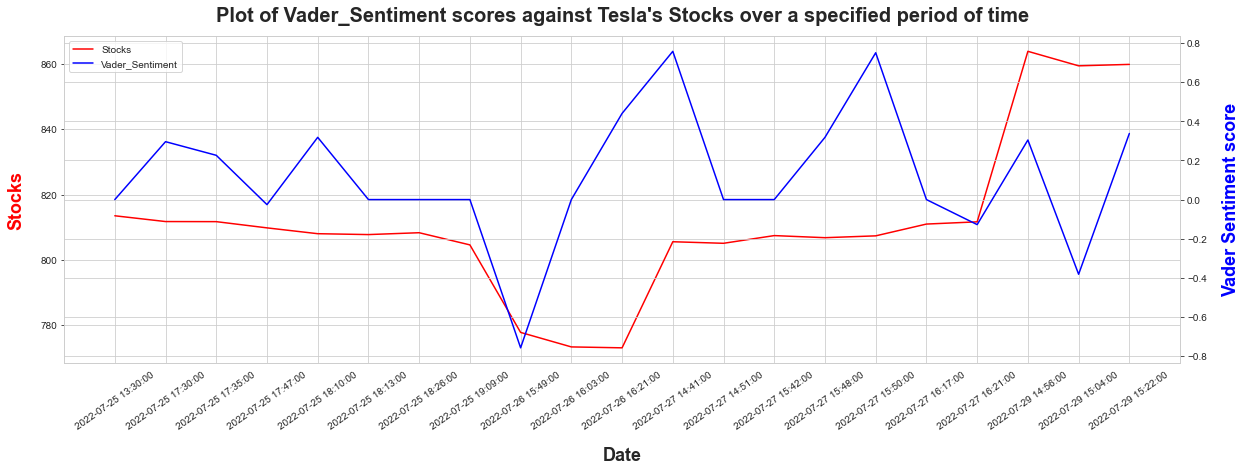

In [137]:
fig, ax = plt.subplots(figsize = (20, 6))

#Plot the stocks data over the date period
ax.plot(elon_tweets.Date, elon_tweets["Stock value"], color = "red", label = "Stocks")
plt.xticks(rotation=35)

#Set title and label
ax.set_title("Plot of Vader_Sentiment scores against Tesla's Stocks over a specified period of time", weight = "bold", fontsize = 20, pad = 15)
ax.set_xlabel("Date", fontsize = 18, weight = "bold", labelpad = 15)
ax.set_ylabel("Stocks", color = 'r', fontsize = 18, weight = "bold", labelpad = 15)

#Overlay the Vader_sentiment scores plot on the stocks plot
vader_date_ax = ax.twinx()   
#Create a twin axes sharing the x axis and plot the sentiments versus the dates

vader_date_ax.plot(elon_tweets.Date, elon_tweets["vader_sentiments"], color = "blue", label = "Vader_Sentiment")
vader_date_ax.set_ylabel("Vader Sentiment score", color = 'b', fontsize = 18, weight = "bold", labelpad = 15)

#Set the legend to describe both plots
fig.legend(loc = 'upper left', bbox_to_anchor = (0 , 1), bbox_transform=ax.transAxes);

From the graph above where we have the 
- Date column on the x axis, 
- the Stocks on the left-y axis and 
- the Vader Sentiment score on the right-y axis.

A basic look at the graph shows that the the Vader sentiment scores very well resembles the trend of the stock to a reasonable level such that to a degree, if the sentiment is high or low, the stocks also to an extent, rises or falls in line.   

A quite deeper look show that 
- at the most points of the plot, Elon making a neutral or slightly-positive tweet causes a slight decline in the stocks
- and when the tweet is very negative, the stocks drops very sharply
- and also when the tweet is considered very positive, the stock rises to a considerable higher level.

**This shows that to a very large extent, there's a correlation between Elon's tweets and the rise of fall of Tesla's stocks**. Let's confirm our inference by checking out the graph of the BSA_sentiment scores against the stocks.

#### Plot of the BSA_sentiment scores against the stocks over a period of time

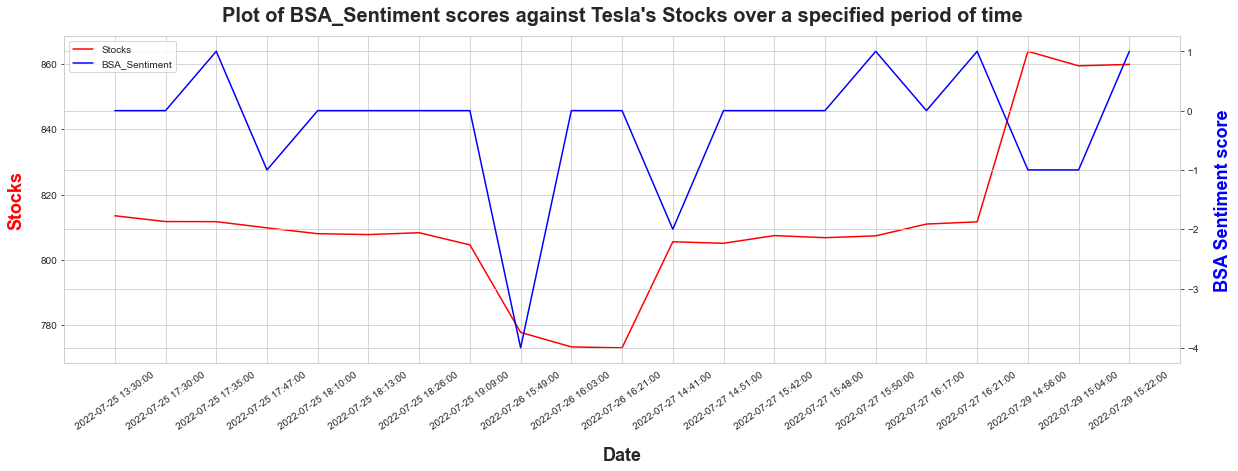

In [139]:
fig, ax = plt.subplots(figsize = (20, 6))

#Plot the stocks data over the date period
ax.plot(elon_tweets.Date, elon_tweets["Stock value"], color = "red", label = "Stocks")
plt.xticks(rotation=35)

#Set title and label
ax.set_title("Plot of BSA_Sentiment scores against Tesla's Stocks over a specified period of time", weight = "bold", fontsize = 20, pad = 15)
ax.set_xlabel("Date", fontsize = 18, weight = "bold", labelpad = 15)
ax.set_ylabel("Stocks", color = 'r', fontsize = 18, weight = "bold", labelpad = 15)

#Overlay the BSA_sentiment scores plot on the stocks plot
bsa_date_ax = ax.twinx()   
#Create a twin axes sharing the x axis and plot the sentiments versus the dates

bsa_date_ax.plot(elon_tweets.Date, elon_tweets["BSA_sentiments"], color = "blue", label = "BSA_Sentiment")
bsa_date_ax.set_ylabel("BSA Sentiment score", color = 'b', fontsize = 18, weight = "bold", labelpad = 15)

#Set the legend to describe both plots
fig.legend(loc = 'upper left', bbox_to_anchor = (0 , 1), bbox_transform=ax.transAxes);

From the graph above where we have the 
- Date column on the x axis, 
- the Stocks on the left-y axis and 
- the BSA Sentiment score on the right-y axis.

A basic look at the graph shows that the the BSA sentiment scores to an extent also resembles the trend of the stock to a reasonable level such that to a degree, if the sentiment is high or low, the stocks also to an extent, rises or falls in line.   

A quite deeper look show that 
- at the most points of the plot, Elon making a positive or neutral tweet causes a very slight change in the stocks, but the stocks still maintain a balance in this case
- and when the tweet is very negative, the stocks drops very sharply
- and also when the tweet over time moves from (Neutral or Positive) to Negative or vice versa, there's a considerable change in the stocks level. The only exception been when the tweets maintain its sentiment from Neutral to Positive for example. Any other big change in the sentiments of the tweet cause a change in the stocks.

**This also confirms our earlier inference that to a very large extent, there's a correlation between Elon's tweets and the rise of fall of Tesla's stocks**.

# Conclusion

From the analysis and graphs produced above, it can be inferred that there's a general relationship between the tweets and the Stocks.  
This proves that the sentiment of tweets can be considered a determining factor to the trend of a stock; be it positive or negative.

One thing to note is that there are several factors that causes stocks to rise or fall but from this analysis, we can infer that the tweets of the company owner is among these factors.

The analysis can very much be improved by working with a longer daterange such as a year, two or more. This will provide more insights and provide more details that the week data doesn't cover due to the restriction of the stocks API.